## [DACON] 진동데이터 활용 충돌체 탐지 AI 경진대회
## 두부(팀명) (Team name)
## 2020년 7월 17일 (제출날짜) (Submission date)

## 0. 들어가기에 앞서

data에 대한 EDA를 하고 insight를 얻을 겸, 선형모델과 Tree모델을 통해 target을 예측해 보았습니다.\
이 과정에서 얻은 insight를 통해 CNN에서 간단한 변수 하나와, 적절한 시간까지의 데이터 사용을 통해 성능을 올릴 수 있었습니다. \
또한 대회 metric이 굉장히 예민하기 때문에 선형모델과 Tree모델의 성능이 좋지 않더라도 \
앙상블을 한다면 조금이라도 성능이 오르지 않을까 해서 대회 초반에 시행해 보았습니다 

결과적으로, 

(CNN1 + CNN2) LB : 0.0035 \
(CNN1 + CNN2)*0.5 + (CNN3 + CNN4)*0.5 LB : 0.003 \
(CNN1 + CNN2)*0.5 + (CNN3 + CNN4 + Lasso_RF)*0.5 LB : 0.0025 \

로서 약간의 성능 향상을 얻을 수 있었습니다

(EDA부분은 PPT에 담아 두었습니다)

## 1. 라이브러리 및 데이터
## Library & Data

In [274]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import random
random.seed(777)
np.random.seed(1)

import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from tqdm import tqdm
import lightgbm as lgbm
import re
from sklearn.ensemble import RandomForestRegressor 
os.getcwd()
os.chdir('C:\\Users\\ParkGiChan\\Desktop\\DataAnalysis\\DACON_KAERI')

## 2. 데이터 전처리
## Data Cleansing & Pre-Processing  

In [275]:
train = pd.read_csv("train_features.csv")
test = pd.read_csv("test_features.csv")
y_train = pd.read_csv("train_target.csv", index_col=0)
y_test = pd.read_csv("sample_submission.csv", index_col=0)

Data shpae을 바꿔줍니다

In [276]:
def transform_df(train):
    col = 'S1'
    train['Time'] = (train['Time']*1000000).astype('int')
    example = train.loc[:,['Time',col,'id']].copy()
    example = example.set_index(['id','Time']).unstack()
    example.columns = example.columns.map(lambda x: '{}_{}'.format(x[0], x[1]))
    example = example.reset_index()
    temp=example.copy()['id']
    
    for k in train.columns[2:]:
    
        example = train.loc[:,['Time',k,'id']].copy()
        example = example.set_index(['id','Time']).unstack()
        example.columns = example.columns.map(lambda x: '{}_{}'.format(x[0], x[1]))
        example = example.reset_index()
        temp = pd.merge(temp, example, on='id')
     
    temp.index = temp['id']
    temp.drop('id', axis=1, inplace=True)

    return temp

In [277]:
X_train = transform_df(train)
X_test = transform_df(test)
df = X_train.append(X_test)

In [278]:
df

,S1_0,S1_4,S1_8,S1_12,S1_16,S1_20,S1_24,S1_28,S1_32,S1_36,...,S4_1460,S4_1464,S4_1468,S4_1472,S4_1475,S4_1480,S4_1484,S4_1488,S4_1492,S4_1496
id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.00000,0.000000,...,182471.50,191195.90,189541.300,175185.20,147667.70,106792.60,58248.420,3015.649,-49795.1400,-95687.360
1,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.00000,0.000000,...,-714642.40,-784526.90,-810421.700,-794061.90,-735795.10,-641504.60,-528058.800,-394603.000,-246912.0000,-75997.950
2,0.0,0.0,0.0,0.0,-0.000092,-6.843146e-03,-0.155149,-3.675771,-25.13809,-99.968380,...,-47886.90,-17237.54,5774.739,21298.59,26430.76,23816.36,15415.150,2599.393,-12329.6000,-27459.080
3,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.00000,0.000000,...,170625.80,152155.30,128479.700,98125.52,65940.75,31120.66,-1469.299,-32862.860,-60362.7700,-84775.410
4,0.0,0.0,0.0,0.0,0.000000,3.230998e-07,0.000015,-0.000178,-0.01209,-0.629234,...,242069.10,254386.80,257263.500,249739.50,229809.80,196475.00,153669.900,102289.900,49481.1200,-3115.911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.00000,0.000000,...,-190023.90,-247566.20,-288057.100,-316379.30,-328605.30,-328016.50,-315775.200,-293865.800,-265466.3000,-232333.300
3496,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.00000,0.000000,...,-155721.40,-150691.80,-141373.500,-127431.20,-110918.50,-91823.54,-73415.460,-55572.000,-39766.0200,-25087.010
3497,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.00000,0.000000,...,-81154.78,-70202.47,-58321.840,-44864.54,-32221.10,-20228.65,-11038.300,-4301.394,-336.3169,1674.353


각 센서별로 dataframe을 따로 만들어 줍니다

In [279]:
df_S1 = df.iloc[:,np.where(df.columns.str.find('S1') == 0)[0]]
df_S2 = df.iloc[:,np.where(df.columns.str.find('S2') == 0)[0]]
df_S3 = df.iloc[:,np.where(df.columns.str.find('S3') == 0)[0]]
df_S4 = df.iloc[:,np.where(df.columns.str.find('S4') == 0)[0]]

In [280]:
def first_arrive_time(df_S1):
    value = []
    for i in range(0, len(df_S1)):
        value.append(np.where((df_S1.loc[i] != 0) == True)[0][0])
    
    return value

각 센서별로 dataframe을 만들고, 샘플마다 제일 처음 도달한 센서, 마지막으로 도달한 센서를 추출하고 \
4개의 센서중 가장 최초로 파장이 도달한 시간을 추출합니다 \
통계량의 경우 4개의 센서중 맨 처음 파장이 닿은 센서만을 사용하였습니다.

In [281]:
df_S1_time = first_arrive_time(df_S1)
df_S2_time = first_arrive_time(df_S2)
df_S3_time = first_arrive_time(df_S3)
df_S4_time = first_arrive_time(df_S4)

In [282]:
temp = pd.DataFrame({'S1_arr_time':df_S1_time,'S2_arr_time':df_S2_time, 'S3_arr_time':df_S3_time,'S4_arr_time':df_S4_time})
temp.index = df.index

In [283]:
def get_first_sensor(temp):
    value = []
    for i in range(0, len(temp)):
        value.append(int(temp.iloc[i,0:4].astype('int').argmin()[1]))
    return value

def get_last_sensor(temp):
    value = []
    for i in range(0, len(temp)):
        value.append(int(temp.iloc[i,0:4].astype('int').argmax()[1]))
    return value

temp['first'] = get_first_sensor(temp)
temp['last'] = get_last_sensor(temp)
temp['time'] = temp.iloc[:,0:4].min(axis=1)

In [284]:
temp

,S1_arr_time,S2_arr_time,S3_arr_time,S4_arr_time,first,last,time
id,,,,,,,
0,10,10,28,22,1,3,10
1,27,5,18,14,2,1,5
2,4,22,22,17,1,2,4
3,19,8,18,12,2,1,8
4,5,23,20,14,1,2,5
...,...,...,...,...,...,...,...
3495,16,31,7,5,4,2,5
3496,18,14,9,5,4,1,5
3497,24,2,28,21,2,3,2


stride를 3으로 잡고, df.diff(window=3)을 시행해줍니다

In [285]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
minmax_scaler = MinMaxScaler()
std_scaler = StandardScaler()

In [286]:
def subtract_each_col(df, stride):
    temp = df.copy()
    for i in range(stride, len(temp.columns)):
        temp[temp.columns[i-stride] + "-" + temp.columns[i]] = temp[temp.columns[i-stride]]-temp[temp.columns[i]]
        
    return temp.iloc[:,len(df.columns):]

In [287]:
df2_S1 = df.iloc[:,np.where(df.columns.str.find('S1') == 0)[0]]
df2_S2 = df.iloc[:,np.where(df.columns.str.find('S2') == 0)[0]]
df2_S3 = df.iloc[:,np.where(df.columns.str.find('S3') == 0)[0]]
df2_S4 = df.iloc[:,np.where(df.columns.str.find('S4') == 0)[0]]

df2_S1 = subtract_each_col(df_S1,3)
df2_S2 = subtract_each_col(df_S2,3)
df2_S3 = subtract_each_col(df_S3,3)
df2_S4 = subtract_each_col(df_S4,3)


df_MV에, 추출한 통계량들을 넣어 줍니다

In [288]:
df_MV = temp.copy()

In [289]:
first_time = []
for i in range(0, len(temp)):
    index = temp['first'][i]
    first_time.append(temp.iloc[i,index-1])
    
df_MV['first_time'] = first_time

df_temp1에는, 처음 닿은 센서값을 넣고 \
df_temp2에는, 처음 닿은 센서값의 기울기를 넣어줍니다

In [290]:
df_temp1 = df_S1.copy()
df_temp1.columns = ['first_signal_' + str(i) for i in range(0, 375)]

df_temp2 = df_S1.copy().iloc[:,0:372]
df_temp2.columns = ['first_signal_slope_' + str(i) for i in range(0, 372)]

In [291]:
for i in range(0, 3500):
    exec("temp_temp1 = " + "df_S" + str(temp['first'][i]))
    exec("temp_temp2 = " + "df2_S" + str(temp['first'][i]))
    df_temp1.loc[i] = np.array(temp_temp1.loc[i])
    df_temp2.loc[i] = np.array(temp_temp2.loc[i])

최초로 도착한 센서값을 sample별로 정규화한 이후, 기울기를 넣어 줍니다

In [292]:
std_scaler.fit(df_temp1.T)
df_temp1_scale = pd.DataFrame(std_scaler.transform(df_temp1.T)).T

In [293]:
df_temp1_scale.columns = df_temp1.columns
df_temp1_scale.index = df_temp1.index
ttt = subtract_each_col(df_temp1_scale,5)

In [294]:
df_MV['first_stdsignal_slope_max-min'] = ttt.max(axis=1) - ttt.min(axis=1)

df_MV['first_stdsignal_slope_max'] = ttt.max(axis=1)
df_MV['first_stdsignal_slope_abs_max'] = abs(ttt).max(axis=1)
df_MV['first_stdsignal_slope_var'] = ttt.var(axis=1)
df_MV['first_stdsignal_slope_abs_mean'] = abs(ttt).mean(axis=1)


In [295]:
df_MV['first_signal_max'] = df_temp1.max(axis=1)
df_MV['first_signal_abs_max'] = abs(df_temp1).max(axis=1)
df_MV['first_signal_slope_max'] = df_temp2.max(axis=1)
df_MV['first_signal_abs_slope_max'] = abs(df_temp2).max(axis=1)

df_MV['first_signal_slope_max-min'] = df_temp2.max(axis=1) - df_temp2.min(axis=1)

df_MV['first_signal_var'] = df_temp1.var(axis=1)
df_MV['first_signal_slope_var'] = df_temp2.var(axis=1)

기울기의 max - min, 정규화한 이후 기울기의 max - min이 각각 V,M과 깊은 관련이 있음을 알 수 있습니다.

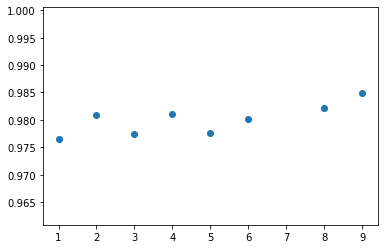

In [296]:
corr=[]
for i in range(0,10):
    index = df_MV[df_MV['first_time'] == i].index
    index = index[index <= 2800]
    corr.append(np.corrcoef(df_MV.loc[index,'first_signal_slope_max-min'], y_train['V'][index])[0][1])
    
plt.scatter(range(0,10), corr)

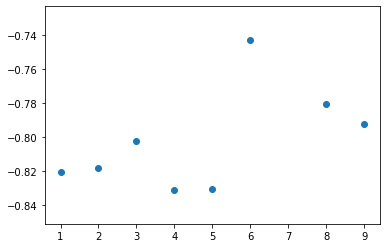

In [297]:
corr=[]
for i in range(0,10):
    index = df_MV[df_MV['first_time'] == i].index
    index = index[index <= 2800]
    corr.append(np.corrcoef(df_MV.loc[index,'first_stdsignal_slope_max-min'], y_train['M'][index])[0][1])
    
plt.scatter(range(0,10), corr)

M,V를 예측하기 위해 만든 변수들에서 제곱..5제곱..(1/2)제곱..(1/5)제곱 등을 만들어줍니다

In [298]:
df_MV_temp = df_MV.iloc[:,7:].copy()

In [299]:
df_MV_temp_2 = df_MV_temp**2
df_MV_temp_2.columns = df_MV_temp.columns + "_2"

df_MV_temp_3 = df_MV_temp**3
df_MV_temp_3.columns = df_MV_temp.columns + "_3"

df_MV_temp_4 = df_MV_temp**4
df_MV_temp_4.columns = df_MV_temp.columns + "_4"

df_MV_temp_5 = df_MV_temp**5
df_MV_temp_5.columns = df_MV_temp.columns + "_5"



df_MV_temp_12 = df_MV_temp**(1/2)
df_MV_temp_12.columns = df_MV_temp.columns + "_1/2"

df_MV_temp_13 = df_MV_temp**(1/3)
df_MV_temp_13.columns = df_MV_temp.columns + "_1/3"

df_MV_temp_14 = df_MV_temp**(1/4)
df_MV_temp_14.columns = df_MV_temp.columns + "_1/4"

df_MV_temp_15 = df_MV_temp**(1/5)
df_MV_temp_15.columns = df_MV_temp.columns + "_1/5"


df_MV_temp = pd.merge(df_MV_temp, df_MV_temp_2, on='id')
df_MV_temp = pd.merge(df_MV_temp, df_MV_temp_3, on='id')
df_MV_temp = pd.merge(df_MV_temp, df_MV_temp_4, on='id')
df_MV_temp = pd.merge(df_MV_temp, df_MV_temp_5, on='id')


df_MV_temp = pd.merge(df_MV_temp, df_MV_temp_12, on='id')
df_MV_temp = pd.merge(df_MV_temp, df_MV_temp_13, on='id')
df_MV_temp = pd.merge(df_MV_temp, df_MV_temp_14, on='id')
df_MV_temp = pd.merge(df_MV_temp, df_MV_temp_15, on='id')

X,Y를 예측할 때는 각 센서별 도착한 시간, 도착한 시간들의 차, 차의 절대값, 합만 사용합니다

In [300]:
def subtract_each_col(temp):
    temp2 = temp.copy()
    for i in range(0, len(temp2.columns)-1):
        for j in range(i+1, len(temp2.columns)):
            temp[temp.columns[i] + "-" + temp.columns[j]] = temp2.iloc[:,i] - temp2.iloc[:,j]
    
    return temp.iloc[:,len(temp2.columns):]

def plus_each_col(temp):
    temp5 = temp.copy()
    for i in range(0, len(temp5.columns)-1):
        for j in range(i+1, len(temp5.columns)):
            temp[temp.columns[i] + "+" + temp.columns[j]] = temp5.iloc[:,i] + temp5.iloc[:,j]
            
    return temp.iloc[:,len(temp5.columns):]


In [301]:
temp2 = temp.iloc[:,0:4].copy()

In [302]:
tt = temp2.copy()
subtract = subtract_each_col(tt)

tt = temp2.copy()
plus = plus_each_col(tt)

In [303]:
X_df = pd.merge(temp, subtract, on='id')
X_df = pd.merge(X_df, abs(subtract), on='id')
X_df = pd.merge(X_df, plus, on='id')

In [304]:
X_df['first_time'] = temp['time']
X_df['first'] = temp['first']

In [305]:
X_df= X_df.dropna(axis=1) 

## 4. 변수 선택 및 모델 구축
## Feature Engineering & Initial Modeling  

## 5. 모델 학습 및 검증
## Model Tuning & Evaluation

# 1. Lasso, RF

In [306]:
def E22(y_true, y_pred):
    '''
    y_true: dataframe with true values of X,Y,M,V
    y_pred: dataframe with pred values of X,Y,M,V
    
    return: sum of mass and velocity's mean squared percentage error
    '''
    
    _t, _p = np.array(y_true)[:,2:], np.array(y_pred)[:,2:]
    
    
    return np.mean(np.sum(np.square((_t - _p) / (_t + 1e-06)), axis = 1))

def E11(y_true, y_pred):
    '''
    y_true: dataframe with true values of X,Y,M,V
    y_pred: dataframe with pred values of X,Y,M,V
    
    return: distance error normalized with 2e+04
    '''
    
    _t, _p = np.array(y_true)[:,:2], np.array(y_pred)[:,:2]
    
    return np.mean(np.sum(np.square(_t - _p), axis = 1) / 2e+04)

# Lasso _ V 

In [331]:
y_test = pd.read_csv("sample_submission.csv", index_col=0)

In [332]:
y_val_save = y_train.copy()
y_val_save.iloc[:,:] = 0

In [333]:
from sklearn import linear_model
from sklearn.model_selection import GroupKFold

num_fold=5
score = []
for Time in [1,2,3,4,5,6,7,8,9,10,11]:
    T = Time
    t1 = df_MV_temp[df_MV_temp['first_time'] == T]
    t1 = t1.drop(['first_time'], axis=1)

    X_train_temp = t1.loc[t1.index < 2800]
    X_test_temp = t1.loc[t1.index >= 2800]

    y_train_temp = y_train.loc[t1.index]
    y_train_temp = y_train_temp[y_train_temp.index < 2800]
    
    kf = KFold(n_splits=num_fold, shuffle=True, random_state=777)
    for n_fold, (trn_idx, val_idx) in enumerate(kf.split(X_train_temp)):
        trn_x, trn_y = X_train_temp.iloc[trn_idx], y_train_temp.iloc[trn_idx]
        val_x, val_y = X_train_temp.iloc[val_idx], y_train_temp.iloc[val_idx]
        
        #model = RandomForestRegressor(n_jobs=-1, random_state=777, n_estimators=1000, max_features=0.7)
        clf = linear_model.Lasso(alpha=0, random_state=777)
        clf.fit(trn_x, trn_y['V'])
        y_pred = clf.predict(val_x)
        #print(abs(val_y['V'] - y_pred).mean())
        score.append(abs(val_y['V'] - y_pred).mean())
        y_test.loc[X_test_temp.index,'V'] += clf.predict(X_test_temp)/num_fold
        y_val_save.loc[val_x.index,'V'] = y_pred
#print(E22(val_y, y_pred))

In [334]:
print(np.array(score).mean())
V_value = y_val_save['V'].append(y_test['V'])

0.006277759338198963


# Lasso _ M
M의 경우, (4개의 센서중 파장이 먼저 닿은 센서의 적분값 / V)와 아주 깊은 관련이 있습니다.\
하지만, 센서에 파장이 언제 도착했느냐에 따라, 어느 Time까지의 적분값이 가장 M과 관련이 깊은지가 다르기 때문에 \
도착한 시간에 따라 다른 시간까지의 적분값을 예측 V로 나눠 변수로 사용하였습니다.


In [335]:
score = []
wow = []
for Time in [1,2,3,4,5,6,7,8,9,10,11]:
    T = Time
    
    df_temp1_abs_cumsum = abs(df_temp1).cumsum(axis=1)

    index = temp[(temp['time'] == Time)].index
    index = index[index<2800]
    max_corr = []
    for col in df_temp1_abs_cumsum.columns:
        max_corr.append(np.corrcoef(df_temp1_abs_cumsum.loc[index][col]/y_train.loc[index,'V'], y_train.loc[index,'M'])[0][1])
    
    
    wow.append(np.array(max_corr)[~np.isnan(np.array(max_corr))].max())
    
    
    max_corr = [0 if x != x else x for x in max_corr]
    col = df_temp1.columns[np.array(max_corr).argmax()]
    
    index = temp[(temp['time'] == Time)].index
    magic_col1 = df_temp1_abs_cumsum.loc[index, col]/V_value.loc[index]      
    magic_col2 = df_temp1_abs_cumsum.loc[index, col]/V_value.loc[index]**(1/2)
    magic_col3 = df_temp1_abs_cumsum.loc[index, col]/V_value.loc[index]**2
    magic_col4 = df_temp1_abs_cumsum.loc[index, col]/V_value.loc[index]**(1/3)
    magic_col5 = df_temp1_abs_cumsum.loc[index, col]/V_value.loc[index]**3
    magic_col6 = df_temp1_abs_cumsum.loc[index, col]/V_value.loc[index]**(1/4)
    magic_col7 = df_temp1_abs_cumsum.loc[index, col]/V_value.loc[index]**4
    
    t1 = df_MV_temp[df_MV_temp['first_time'] == T]
    t1 = t1.drop(['first_time'], axis=1)
    
    t1['V'] = V_value
    t1['magic_col1'] = np.array(magic_col1)
    t1['magic_col1_2'] = np.array(magic_col1)**2
    t1['magic_col1_1/2'] = np.array(magic_col1)**(1/2)
    
    t1['magic_col2'] = np.array(magic_col2)
    t1['magic_col2_2'] = np.array(magic_col2)**2
    t1['magic_col2_1/2'] = np.array(magic_col2)**(1/2)
    
    t1['magic_col3'] = np.array(magic_col3)
    t1['magic_col3_2'] = np.array(magic_col3)**2
    t1['magic_col3_1/2'] = np.array(magic_col3)**(1/2)
    
    t1['magic_col4'] = np.array(magic_col4)
    t1['magic_col4_2'] = np.array(magic_col4)**2
    t1['magic_col4_1/2'] = np.array(magic_col4)**(1/2)
    
    t1['magic_col5'] = np.array(magic_col5)
    t1['magic_col5_2'] = np.array(magic_col5)**2
    t1['magic_col5_1/2'] = np.array(magic_col5)**(1/2)
    
    t1['magic_col6'] = np.array(magic_col6)
    t1['magic_col6_2'] = np.array(magic_col6)**2
    t1['magic_col6_1/2'] = np.array(magic_col6)**(1/2)
    
    t1['magic_col7'] = np.array(magic_col7)
    t1['magic_col7_2'] = np.array(magic_col7)**2
    t1['magic_col7_1/2'] = np.array(magic_col7)**(1/2)
    
    X_train_temp = t1.loc[t1.index < 2800]
    X_test_temp = t1.loc[t1.index >= 2800]

    y_train_temp = y_train.loc[t1.index]
    y_train_temp = y_train_temp[y_train_temp.index < 2800]
    
    kf = KFold(n_splits=num_fold, shuffle=True, random_state=777)
    for n_fold, (trn_idx, val_idx) in enumerate(kf.split(X_train_temp)):
        trn_x, trn_y = X_train_temp.iloc[trn_idx], y_train_temp.iloc[trn_idx]
        val_x, val_y = X_train_temp.iloc[val_idx], y_train_temp.iloc[val_idx]
        
        clf = linear_model.Lasso(alpha=0, random_state=777)
        clf.fit(trn_x, trn_y['M'])
        y_pred = clf.predict(val_x)
        #print(abs(val_y['V'] - y_pred).mean())
        score.append(abs(val_y['M'] - y_pred).mean())
        y_test.loc[X_test_temp.index,'M'] += clf.predict(X_test_temp)/num_fold
        y_val_save.loc[val_x.index,'M'] = y_pred

In [336]:
np.array(score).mean()

1.9559844205973747

In [337]:
y_val_save['M'] = np.clip(y_val_save['M'], 25, 175)
y_val_save['V'] = np.clip(y_val_save['V'], 0.2, 1)

In [338]:
E22(y_train, y_val_save)*0.5

0.000574906155846838

센서에 파장이 도착한 시간에 따라, (적절한 시간까지의 적분값 / V)이 M과 깊은 관련이 있음을 알 수 있습니다.

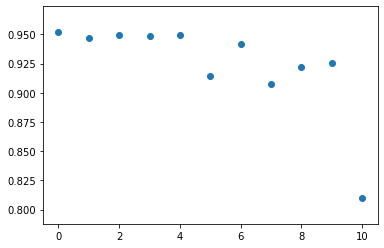

In [339]:
plt.scatter(range(0,11),wow)

# check 

In [340]:
y_test['M'] = np.clip(y_test['M'], 1, 200)
y_test['V'] = np.clip(y_test['V'], 0.01, 1)

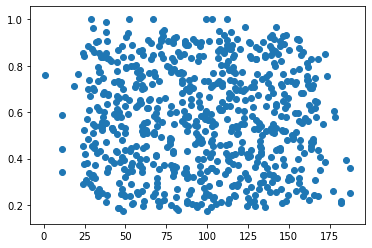

In [341]:
plt.scatter(y_test['M'], y_test['V'])

# Lasso _ X, Y

In [342]:
from sklearn import linear_model
from sklearn import linear_model
clf = linear_model.MultiTaskLasso(alpha=0)


num_fold=5
score = []
for Time in [1,2,3,4,5,6,7,8,9,10,11]:
    T = Time
    t1 = X_df[X_df['first_time'] == T]
    t1 = t1.drop(['first_time'], axis=1)

    X_train_temp = t1.loc[t1.index < 2800]
    X_test_temp = t1.loc[t1.index >= 2800]

    y_train_temp = y_train.loc[t1.index]
    y_train_temp = y_train_temp[y_train_temp.index < 2800]

    kf = KFold(n_splits=num_fold, shuffle=True, random_state=777)
    for n_fold, (trn_idx, val_idx) in enumerate(kf.split(X_train_temp)):
        trn_x, trn_y = X_train_temp.iloc[trn_idx], y_train_temp.iloc[trn_idx]
        val_x, val_y = X_train_temp.iloc[val_idx], y_train_temp.iloc[val_idx]
        
        #clf = linear_model.Lasso(alpha=0, normalize=True)
        
        clf = linear_model.MultiTaskLasso(alpha=0, random_state=777)
        clf.fit(trn_x, trn_y[['X','Y']])
        y_pred = clf.predict(val_x)
        #print(abs(val_y['V'] - y_pred).mean())
        #score.append(abs(val_y['X'] - y_pred).mean())
        
        y_test.loc[X_test_temp.index,'X'] += clf.predict(X_test_temp)[:,0]/num_fold
        y_val_save.loc[val_x.index,'X'] = y_pred[:,0]
        
        y_test.loc[X_test_temp.index,'Y'] += clf.predict(X_test_temp)[:,1]/num_fold
        y_val_save.loc[val_x.index,'Y'] = y_pred[:,1]
#print(E22(val_y, y_pred))

In [343]:
y_val_save['X'] = np.clip(y_val_save['X'], -400, 400)
y_val_save['Y'] = np.clip(y_val_save['Y'], -400, 400)

In [344]:
E11(y_train, y_val_save)

0.01173017088724574

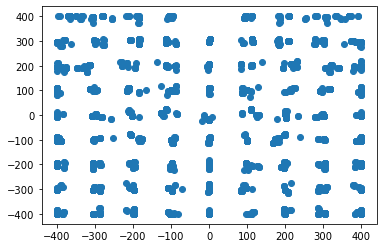

In [345]:
plt.scatter(y_val_save['X'], y_val_save['Y'])

In [346]:
y_test['X'] = np.clip(y_test['X'], -400, 400)
y_test['Y'] = np.clip(y_test['Y'], -400, 400)

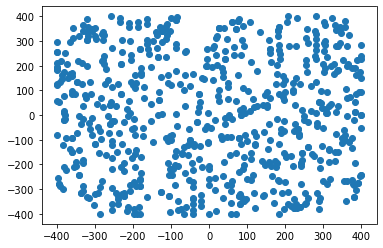

In [347]:
plt.scatter(y_test['X'], y_test['Y'])

In [348]:
y_test_lasso = y_test.copy()

# Random Forest _ X, Y

In [349]:
y_test = pd.read_csv("sample_submission.csv", index_col=0)

In [350]:
y_val_save = y_train.copy()
y_val_save.iloc[:,:] = 0

In [351]:
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold

model = RandomForestRegressor(n_jobs=-1, random_state=777, n_estimators=1000, max_features=0.7)

y_train_temp = y_train[['X','Y']]
X_train_temp = X_df.iloc[0:2800,:]
X_test_temp = X_df.iloc[2800:,:]

group_kfold = GroupKFold(n_splits=5)
groups = y_train['X'].astype('str') + "_" + y_train['Y'].astype('str') + \
    "_" + y_train['M'].astype('str') + "_" + y_train['V'].astype('str') + "_" + df_MV_temp['first_time'][0:2800].astype('str')
#groups = y_train['M'].astype('str') + "_" + y_train['V'].astype('str')
group_kfold.get_n_splits(df_MV_temp, y_train_temp, groups)


for n_fold, (trn_idx, val_idx) in enumerate(group_kfold.split(X_train_temp, y_train_temp, groups)):
    trn_x, trn_y = X_train_temp.iloc[trn_idx], y_train_temp.iloc[trn_idx]
    val_x, val_y = X_train_temp.iloc[val_idx], y_train_temp.iloc[val_idx]
        
    model.fit(trn_x, trn_y)
    y_pred = model.predict(val_x)
    y_val_save.iloc[val_idx,0:2] = y_pred
    print(abs(val_y - y_pred).mean())
    print(E22(val_y, y_pred))
    
    y_pred_test = pd.DataFrame(model.predict(X_test_temp))
    
    y_test['X'] += np.array(y_pred_test[0]/5)
    y_test['Y'] += np.array(y_pred_test[1]/5)

X    0.156607
Y    0.302679
dtype: float64
0.0
X    0.248571
Y    0.295714
dtype: float64
0.0
X    0.205179
Y    0.318214
dtype: float64
0.0
X    0.253571
Y    0.322500
dtype: float64
0.0
X    0.130893
Y    0.209643
dtype: float64
0.0


In [352]:
y_val_save['X'] = np.clip(y_val_save['X'], -400, 400)
y_val_save['Y'] = np.clip(y_val_save['Y'], -400, 400)

In [353]:
E11(y_train, y_val_save)

0.00014207357142857142

# Random Forest _ M, V
똑같은 과정을 RF로 시행해줍니다


In [354]:
drop_list = list(set(np.where(df_MV_temp.values >= np.finfo(np.float32).max)[1]))

In [355]:
df_MV_temp.drop(df_MV_temp.columns[drop_list], axis=1, inplace=True)

In [356]:
from sklearn import linear_model
from sklearn.model_selection import GroupKFold

model = RandomForestRegressor(n_jobs=-1, random_state=777, n_estimators=1000, max_features=0.3)

num_fold=5
score = []
for Time in [1,2,3,4,5,6,7,8,9,10,11]:
    T = Time
    t1 = df_MV_temp[df_MV_temp['first_time'] == T]
    t1 = t1.drop(['first_time'], axis=1)

    X_train_temp = t1.loc[t1.index < 2800]
    X_test_temp = t1.loc[t1.index >= 2800]

    y_train_temp = y_train.loc[t1.index]
    y_train_temp = y_train_temp[y_train_temp.index < 2800]
    
    kf = KFold(n_splits=num_fold, shuffle=True, random_state=777)
    for n_fold, (trn_idx, val_idx) in enumerate(kf.split(X_train_temp)):
        trn_x, trn_y = X_train_temp.iloc[trn_idx], y_train_temp.iloc[trn_idx]
        val_x, val_y = X_train_temp.iloc[val_idx], y_train_temp.iloc[val_idx]
        
        #clf = linear_model.Lasso(alpha=0)
        model.fit(trn_x, trn_y['V'])
        y_pred = model.predict(val_x)
        print(abs(val_y['V'] - y_pred).mean())
        score.append(abs(val_y['V'] - y_pred).mean())
        y_test.loc[X_test_temp.index,'V'] += model.predict(X_test_temp)/num_fold
        y_val_save.loc[val_x.index,'V'] = y_pred
#print(E22(val_y, y_pred))

0.0010057142857174818
0.0010914285714332362
0.008834285714289958
0.0016057142857191001
0.0016342857142878245
0.0035460317460373216
0.0011492063492092137
0.002120634920638653
0.0014857142857179594
0.004577777777781676
0.0007821428571465279
0.0032107142857194177
0.0027928571428614893
0.007467857142864348
0.0009035714285755003
0.005450000000001809
0.00148571428571719
0.0026218181818231695
0.0035018181818213647
0.001334545454549712
0.0018818181818223405
0.0017393939393964906
0.008012121212126197
7.384615385168573e-05
0.0011876923076966578
0.001213953488377615
0.0004232558139585927
0.003813953488374284
0.0029395348837257963
0.0030190476190500646
0.0033560000000046864
0.0004580000000057427
0.00023030303030936462
0.0002020202020257177
3.0303030308722747e-05
0.002159259259263477
0.00019622641509924488
0.0014754716981174665
0.002143396226420336
0.000641509433967431
0.0029311475409885285
0.0024600000000059028
0.0011200000000030838
0.000996666666672158
0.002813333333336789
0.027858823529412078
0.

In [357]:
np.array(score).mean()
V_value = y_val_save['V'].append(y_test['V'])

In [358]:
score = []
for Time in [1,2,3,4,5,6,7,8,9,10,11]:
    T = Time
    
    df_temp1_abs_cumsum = abs(df_temp1).cumsum(axis=1)

    index = temp[(temp['time'] == Time)].index
    index = index[index<2800]
    max_corr = []
    for col in df_temp1_abs_cumsum.columns:
        max_corr.append(np.corrcoef(df_temp1_abs_cumsum.loc[index][col]/y_train.loc[index,'V'], y_train.loc[index,'M'])[0][1])

    max_corr = [0 if x != x else x for x in max_corr]
    col = df_temp1.columns[np.array(max_corr).argmax()]
    
    index = temp[(temp['time'] == Time)].index
    magic_col1 = df_temp1_abs_cumsum.loc[index, col]/V_value.loc[index]       
    
    t1 = df_MV_temp[df_MV_temp['first_time'] == T]
    t1 = t1.drop(['first_time'], axis=1)
    
    magic_col1 = df_temp1_abs_cumsum.loc[index, col]/V_value.loc[index]      
    magic_col2 = df_temp1_abs_cumsum.loc[index, col]/V_value.loc[index]**(1/2)
    magic_col3 = df_temp1_abs_cumsum.loc[index, col]/V_value.loc[index]**2
    magic_col4 = df_temp1_abs_cumsum.loc[index, col]/V_value.loc[index]**(1/3)
    magic_col5 = df_temp1_abs_cumsum.loc[index, col]/V_value.loc[index]**3
    magic_col6 = df_temp1_abs_cumsum.loc[index, col]/V_value.loc[index]**(1/4)
    magic_col7 = df_temp1_abs_cumsum.loc[index, col]/V_value.loc[index]**4
    
    t1 = df_MV_temp[df_MV_temp['first_time'] == T]
    t1 = t1.drop(['first_time'], axis=1)
    
    t1['V'] = V_value
    t1['magic_col1'] = np.array(magic_col1)
    t1['magic_col1_2'] = np.array(magic_col1)**2
    t1['magic_col1_1/2'] = np.array(magic_col1)**(1/2)
    
    t1['magic_col2'] = np.array(magic_col2)
    t1['magic_col2_2'] = np.array(magic_col2)**2
    t1['magic_col2_1/2'] = np.array(magic_col2)**(1/2)
    
    t1['magic_col3'] = np.array(magic_col3)
    t1['magic_col3_2'] = np.array(magic_col3)**2
    t1['magic_col3_1/2'] = np.array(magic_col3)**(1/2)
    
    t1['magic_col4'] = np.array(magic_col4)
    t1['magic_col4_2'] = np.array(magic_col4)**2
    t1['magic_col4_1/2'] = np.array(magic_col4)**(1/2)
    
    t1['magic_col5'] = np.array(magic_col5)
    t1['magic_col5_2'] = np.array(magic_col5)**2
    t1['magic_col5_1/2'] = np.array(magic_col5)**(1/2)
    
    t1['magic_col6'] = np.array(magic_col6)
    t1['magic_col6_2'] = np.array(magic_col6)**2
    t1['magic_col6_1/2'] = np.array(magic_col6)**(1/2)
    
    t1['magic_col7'] = np.array(magic_col7)
    t1['magic_col7_2'] = np.array(magic_col7)**2
    t1['magic_col7_1/2'] = np.array(magic_col7)**(1/2)
    X_train_temp = t1.loc[t1.index < 2800]
    X_test_temp = t1.loc[t1.index >= 2800]

    y_train_temp = y_train.loc[t1.index]
    y_train_temp = y_train_temp[y_train_temp.index < 2800]
    
    kf = KFold(n_splits=num_fold, shuffle=True, random_state=777)
    for n_fold, (trn_idx, val_idx) in enumerate(kf.split(X_train_temp)):
        trn_x, trn_y = X_train_temp.iloc[trn_idx], y_train_temp.iloc[trn_idx]
        val_x, val_y = X_train_temp.iloc[val_idx], y_train_temp.iloc[val_idx]
        
        #clf = linear_model.Lasso(alpha=0)
        model.fit(trn_x, trn_y['M'])
        y_pred = model.predict(val_x)
        print(abs(val_y['M'] - y_pred).mean())
        score.append(abs(val_y['M'] - y_pred).mean())
        y_test.loc[X_test_temp.index,'M'] += model.predict(X_test_temp)/num_fold
        y_val_save.loc[val_x.index,'M'] = y_pred

2.8642857142857134
3.3614285714285734
3.392857142857144
3.7228571428571433
2.831428571428573
1.7325396825396835
1.7682539682539677
2.204761904761904
1.9325396825396832
1.971428571428571
1.9348214285714291
2.6183035714285725
1.1129464285714288
2.6691964285714276
1.7897321428571442
2.9508928571428577
1.813392857142858
2.8345454545454554
2.283181818181818
1.3936363636363631
1.8488636363636364
1.739393939393939
1.630681818181817
1.7869230769230777
1.3969230769230778
1.580813953488372
2.934302325581393
2.2046511627906997
1.6773255813953503
1.7095238095238092
2.1805
1.6784999999999997
1.1333333333333329
0.8790404040404051
1.0174242424242423
2.1092592592592587
2.4438679245283037
1.9103773584905663
1.7896226415094347
1.630188679245283
2.0454918032786895
1.5925000000000002
2.085416666666668
2.1754166666666657
1.7916666666666679
5.816176470588234
5.285294117647061
8.523529411764704
7.9529411764705875
7.785937499999998
9.18269230769231
7.296153846153849
16.18846153846154
10.704166666666664
10.893

In [359]:
y_test_rf = y_test.copy()

In [360]:
y_test = (y_test_rf + y_test_lasso)/2


In [361]:
Case5 = y_test.copy()

## 6. 결과 및 결언
## Conclusion & Discussion

In [366]:
Case5.to_csv("Case5.csv")